# More rnn layers

In [1]:
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from scipy.spatial.distance import cosine
from scipy.sparse import csr_matrix
from detoxify import Detoxify
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import nltk
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import os
import string
import gc

In [2]:
from nltk.translate.bleu_score import SmoothingFunction

chencherry = SmoothingFunction()

In [3]:
nltk.download('punkt')

torch.cuda.empty_cache()
gc.collect()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


20

In [4]:
print(torch.cuda.is_available())

True


In [5]:
data_file_path = '../data/internal/data.csv'
train_file_path = '../data/internal/train_data.csv'
valid_file_path = '../data/internal/valid_data.csv'
test_file_path = '../data/internal/test_data.csv'

data = pd.read_csv(data_file_path)
train_data = pd.read_csv(train_file_path)
valid_data = pd.read_csv(valid_file_path)
test_data = pd.read_csv(test_file_path)

In [6]:
train_df = train_data.sample(n = 15000, random_state=1)
valid_df = valid_data.sample(n = 1500, random_state=1)

In [7]:
def remove_punctuation(text):
    """
    Removes punctuation from text

    :param text: text to remove punctuation from
    :return: text without punctuation
    """
    return text.translate(str.maketrans('', '', string.punctuation))

In [8]:
train_df['reference'] = train_df['reference'].apply(remove_punctuation)
train_df['translation'] = train_df['translation'].apply(remove_punctuation)

valid_df['reference'] = valid_df['reference'].apply(remove_punctuation)
valid_df['translation'] = valid_df['translation'].apply(remove_punctuation)

In [9]:
train_df.head()

,id,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
92781,254295,this thing is dead,Thats dead,0.847450,0.350000,0.875859,0.003970
33273,146878,you shut up I wanna see it,You close your eyes I wanna see,0.653026,0.147059,0.998420,0.000834
22857,311558,I thought Id be fucked but Im not,I thought I was gonna be really upset but Im n...,0.660462,0.344828,0.996695,0.000051
18739,297481,resistance is useless so,Resistance is futile so,0.934338,0.034483,0.778996,0.000562
102410,325100,what the hell is going on,What the devils going on in here,0.787813,0.228571,0.900568,0.013883


In [10]:
# combined_texts = pd.concat([train_df['reference'], valid_df['reference'], test_df['reference']])

##### Model part

In [11]:
def nltk_tokenize(sentence):
    """
    Tokenize a sentence using NLTK.

    :param sentence: The sentence to tokenize.
    :return: The tokenized sentence.
    """
    return nltk.word_tokenize(sentence)

In [12]:
def build_vocab(tokenized_texts):
    """
    Build a vocabulary from a list of tokenized texts.

    :param tokenized_texts: A list of tokenized texts.
    :return: The vocabulary.
    """
    counter = Counter()
    for tokens in tokenized_texts:
        counter.update(tokens)

    vocab = {'<pad>': 0, '<unk>': 1}
    for token, freq in counter.items():
        vocab[token] = len(vocab)
    return vocab

In [13]:
def tokens_to_indices(tokenized_sentence, vocab):
    """
    Convert a tokenized sentence to a list of indices using a vocabulary.

    :param tokenized_sentence: The tokenized sentence.
    :param vocab: The vocabulary.
    :return: The list of indices.
    """
    return [vocab.get(token, vocab['<unk>']) for token in tokenized_sentence]

In [14]:
def pad_sequence(seq, max_length):
    """
    Pad a sequence to a maximum length.

    :param seq: The sequence to pad.
    :param max_length: The maximum length.
    :return: The padded sequence.
    """
    seq += [vocab['<pad>']] * (max_length - len(seq))
    return seq

In [15]:
def indices_to_tokens(indices, vocab):
    """
    Convert a list of indices to a list of tokens using a vocabulary.

    :param indices: The list of indices.
    :param vocab: The vocabulary.
    :return: The list of tokens.
    """
    inv_vocab = {index: token for token, index in vocab.items()}
    return [inv_vocab.get(index, '<unk>') for index in indices]

In [16]:
def indices_to_text(indices, vocab):
    """
    Convert a list of indices to a text using a vocabulary.

    :param indices: The list of indices.
    :param vocab: The vocabulary.
    :return: The text.
    """
    index_to_word = {index: word for word, index in vocab.items()}
    
    return ' '.join(index_to_word.get(index, '<unk>') for index in indices if index != vocab['<pad>'])

In [17]:
tokenized_texts = [nltk_tokenize(sentence) for sentence in train_df['reference']]
vocab = build_vocab(tokenized_texts)
max_length = max(len(tokens) for tokens in tokenized_texts)
total_vocab_size = len(vocab)

tokenized_val_texts = [nltk_tokenize(sentence) for sentence in valid_df['reference']]

In [18]:
class TextDataset(Dataset):
    def __init__(self, tokenized_texts, vocab, max_length):
        self.tokenized_texts = tokenized_texts
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, idx):
        indices = tokens_to_indices(self.tokenized_texts[idx], self.vocab)
        source = pad_sequence(indices, self.max_length)
        target = pad_sequence(indices[1:], self.max_length)
        return torch.tensor(source, dtype=torch.long), torch.tensor(target, dtype=torch.long)

In [19]:
train_dataset = TextDataset(tokenized_texts, vocab, max_length)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [20]:
val_dataset = TextDataset(tokenized_val_texts, vocab, max_length)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False) 

In [21]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_rate):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, 
                            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_rate):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, 
                            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output)
        return prediction, hidden, cell

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target):
        hidden, cell = self.encoder(source)
        prediction, hidden, cell = self.decoder(target, hidden, cell)
        return prediction

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
dropout_rate = 0.5
num_layers = 3

encoder = Encoder(
    vocab_size=total_vocab_size,
    embed_size=128,
    hidden_size=128,
    num_layers=num_layers,
    dropout_rate=dropout_rate
).to(device)

decoder = Decoder(
    vocab_size=total_vocab_size,
    embed_size=128,
    hidden_size=128,
    num_layers=num_layers,
    dropout_rate=dropout_rate
).to(device)

seq2seq = Seq2Seq(encoder, decoder).to(device)

In [26]:
loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-4)

##### Custon metric

In [27]:
toxicity_model = Detoxify('original')
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

In [28]:
def get_toxicity_scores(texts, toxicity_model):
    """
    Get the toxicity scores for a batch of texts.
    :param texts: The list of texts to get toxicity scores for.
    :param toxicity_model: The pre-loaded toxicity model.
    :return: The list of toxicity scores for the given texts.
    """
    results = toxicity_model.predict(texts)
    return results['toxicity']

In [29]:
def calculate_batch_semantic_similarity(original_texts, detoxified_texts, similarity_model):
    """
    Calculate the semantic similarity between batches of original texts and their detoxified versions.
    :param original_texts: The list of original texts.
    :param detoxified_texts: The list of detoxified texts.
    :param similarity_model: The pre-loaded sentence similarity model.
    :return: The list of semantic similarity scores between the two batches of texts.
    """
    original_embeddings = similarity_model.encode(original_texts, convert_to_tensor=True)
    detoxified_embeddings = similarity_model.encode(detoxified_texts, convert_to_tensor=True)
    similarity_scores = cdist(original_embeddings.cpu().numpy(), detoxified_embeddings.cpu().numpy(), metric='cosine')
    return 1 - similarity_scores.diagonal()

In [30]:
def calculate_custom_metric(references, predictions, toxicity_model, similarity_model, device):
    """
    Calculate the custom metric for a batch of references and predictions.

    :param references: The list of references.
    :param predictions: The list of predictions.
    :param toxicity_model: The pre-loaded toxicity model.
    :param similarity_model: The pre-loaded sentence similarity model.
    :param device: The device to use.
    :return: The list of custom metric scores for the given references and predictions.
    """
    custom_scores = []
    for ref, pred in tqdm(zip(references, predictions), total=len(references), desc="Calculating Metrics", leave=False):
        ref_lower = ref.lower()
        pred_lower = pred.lower()

        # BLEU score
        bleu_score = sentence_bleu([ref_lower.split()], pred_lower.split(), smoothing_function=SmoothingFunction().method1)

        # Get toxicity score for the predicted text
        detoxified_toxicity = toxicity_model.predict([pred_lower])['toxicity'][0]

        # Get embeddings for original and predicted texts
        original_embedding = similarity_model.encode(ref_lower, convert_to_tensor=True).to(device)
        detoxified_embedding = similarity_model.encode(pred_lower, convert_to_tensor=True).to(device)

        # Ensure the embeddings are 1D tensors
        original_embedding = original_embedding.squeeze()
        detoxified_embedding = detoxified_embedding.squeeze()

        # Compute cosine similarity
        similarity = torch.nn.functional.cosine_similarity(original_embedding.unsqueeze(0), detoxified_embedding.unsqueeze(0))

        # Custom score calculation
        custom_score = bleu_score * (1 - abs(detoxified_toxicity)) * similarity.item()
        custom_scores.append(custom_score)

    return custom_scores

##### Validation function

In [31]:
def validate(model, val_loader, toxicity_model, similarity_model, device):
    """
    Validate the model on a validation set.

    :param model: The model to validate.
    :param val_loader: The validation data loader.
    :param toxicity_model: The pre-loaded toxicity model.
    :param similarity_model: The pre-loaded sentence similarity model.
    :param device: The device to run the similarity model on.
    :return: The average custom score for the given model and validation data.
    """
    model.eval()
    custom_scores = []
    references = []
    predictions = []

    with torch.no_grad():
        for source, target in tqdm(val_loader, desc="Validating", leave=False):
            source, target = source.to(device), target.to(device)
            output = model(source, target[:, :-1])
            predicted_indices = output.argmax(-1)
            pred_texts = [' '.join(indices_to_tokens(indices.cpu().numpy(), vocab)) for indices in predicted_indices]
            ref_texts = [' '.join(indices_to_tokens(indices.cpu().numpy(), vocab)) for indices in target[:, 1:]]
            predictions.extend(pred_texts)
            references.extend(ref_texts)
            
    custom_scores = calculate_custom_metric(references, predictions, toxicity_model, similarity_model, device)
    return np.mean(custom_scores)

#### Training and validation loop

In [32]:
epochs = 5
accumulation_steps = 4
best_metric = float('-inf')

for epoch in range(epochs):
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit='batch') as pbar:
        seq2seq.train()
        
        optimizer.zero_grad()
        
        for batch_idx, (source, target) in enumerate(train_loader):

            seq2seq.train()

            source, target = source.to(device), target.to(device)
            
            output = seq2seq(source, target[:, :-1])
            loss = loss_function(output.permute(0, 2, 1), target[:, 1:])
            loss = loss / accumulation_steps
            
            loss.backward()
            
            if (batch_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)
            
            # Free up memory
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            
            gc.collect()
        
        # End of epoch cleanup
        checkpoint_path = os.path.join("../models/checkpoints/", f"model_3.2_epoch_{epoch+1}.pt")
        pbar.write(f"Checkpoint saved after epoch {epoch+1}")
        
        # Validate the model
        seq2seq.eval()

        val_metric = validate(seq2seq, val_loader, toxicity_model, similarity_model, device)
        if val_metric > best_metric:
            best_metric = val_metric
            best_model_path = '../models/3.2-custom-embeddings.pt'
            torch.save(seq2seq.state_dict(), best_model_path)
        
        pbar.write(f"Finished with score {val_metric}")
        
        # Cleanup at the end of the epoch
        torch.cuda.empty_cache()
        gc.collect()

Epoch 1/5: 100%|██████████| 235/235 [03:14<00:00,  1.54batch/s, loss=2.25]

Checkpoint saved after epoch 1


Epoch 1/5: 100%|██████████| 235/235 [07:11<00:00,  1.54batch/s, loss=2.25]

Finished with score 9.669683673113766e-05


Epoch 2/5: 100%|██████████| 235/235 [04:13<00:00,  1.26batch/s, loss=1.82]

Checkpoint saved after epoch 2


Epoch 2/5: 100%|██████████| 235/235 [08:03<00:00,  2.06s/batch, loss=1.82]

Finished with score 4.984691303307479e-05



Epoch 3/5: 100%|██████████| 235/235 [04:12<00:00,  1.24batch/s, loss=1.78]

Checkpoint saved after epoch 3


Epoch 3/5: 100%|██████████| 235/235 [07:58<00:00,  1.24batch/s, loss=1.78]

Finished with score 2.9602228363757685e-05


Epoch 4/5: 100%|██████████| 235/235 [04:09<00:00,  1.17batch/s, loss=1.69]

Checkpoint saved after epoch 4


Epoch 4/5: 100%|██████████| 235/235 [08:14<00:00,  2.10s/batch, loss=1.69]

Finished with score 2.9602228363757685e-05



Epoch 5/5: 100%|██████████| 235/235 [04:17<00:00,  1.18batch/s, loss=1.68]

Checkpoint saved after epoch 5


Epoch 5/5: 100%|██████████| 235/235 [08:13<00:00,  1.18batch/s, loss=1.68]

Finished with score 7.833120735647453e-05


Epoch 5/5: 100%|██████████| 235/235 [08:13<00:00,  2.10s/batch, loss=1.68]


#### Training takes a lot of time even when training on the gpu (about 5-6 hour for 1 epoch) for all dataset (not sample)

### Testing

In [ ]:
# full_model = Seq2Seq(encoder, decoder).to(device)

In [33]:
def sequence_processor(texts, max_len, tokenizer, vocab):
    """
    Process a list of texts into padded sequences for PyTorch.
    :param texts: The list of texts to process.
    :param max_len: The maximum length of the sequences.
    :param tokenizer: The tokenizer function to use.
    :param vocab: The vocabulary to use for token to index conversion.
    :return: A tensor of padded sequences.
    """
    tokenized_texts = [tokenizer(text) for text in texts]
    indexed_texts = [tokens_to_indices(t, vocab) for t in tokenized_texts]
    padded_texts = [pad_sequence(t, max_len) for t in indexed_texts]
    return torch.tensor(padded_texts, dtype=torch.long)

In [34]:
test_data.head()

,id,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,289945,the curse of death is on him!,It's got a death curse!,0.845815,0.200000,0.876750,0.006088
1,480510,but then you'll know I'm gonna beat you up by ...,"But then, you'll know deep down that I beat yo...",0.788745,0.085271,0.963052,0.000903
2,107858,"Blondie, come out, 3 seconds, and you'll burn.",Blondie Come on out 3 seconds and you burn One...,0.799032,0.203390,0.992113,0.016989
3,39034,everyone knows if a woman starts poking her no...,Everyone knows when a bird starts poking her n...,0.862760,0.164948,0.706885,0.000631
4,140946,"and your eyes, my God, have smoked my foetus.","And Your eyes, my God, they have seen me in th...",0.767273,0.148148,0.973932,0.000100


In [35]:
sample_test_data = test_data.sample(random_state=1, n=1000)

In [36]:
seq2seq.eval() 

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(12113, 128)
    (lstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(12113, 128)
    (lstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=128, out_features=12113, bias=True)
  )
)

In [37]:
test_texts = sample_test_data['reference'].tolist()
test_seqs = sequence_processor(test_texts, max_length, nltk_tokenize, vocab)

# Create a tensor for the second input with zeros
test_seq_input_2 = torch.zeros_like(test_seqs)

# Move the tensors to the correct device
test_seqs, test_seq_input_2 = test_seqs.to(device), test_seq_input_2.to(device)

In [38]:
with torch.no_grad():
    predictions_seq = seq2seq(test_seqs, test_seq_input_2)

In [39]:
predicted_indices = predictions_seq.argmax(dim=-1).cpu().numpy()

In [40]:
def indices_to_text(indices, vocab):
    """
    Convert a list of indices to a text using a vocabulary.

    :param indices: The list of indices to convert.
    :param vocab: The vocabulary mapping words to indices.
    :return: The text.
    """
    if isinstance(indices, torch.Tensor):
        indices = indices.tolist()

    index_to_word = {index: word for word, index in vocab.items()}
    return ' '.join(index_to_word.get(index, '<unk>') for index in indices if index != vocab['<pad>'])

In [41]:
predicted_texts = [indices_to_text(seq, vocab) for seq in predicted_indices]

In [42]:
sample_test_data['predicted'] = predicted_texts

In [43]:
sample_test_data.head()

,id,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,predicted
3841,187371,"""a fool's mercy allowed me to escape.""","""A madman's mercy bade thee run away.""",0.712329,0.000000,0.993162,0.003678,the the the the the the the the the the the th...
12898,201094,to invent crazy theories...... and look for me...,To keep us spinning wild theories and chasing ...,0.684736,0.091743,0.858899,0.000959,the the the the the the the the the the the th...
15032,575586,I'm afraid they're both dead.,"Dead of their wounds, I'm afraid, both of them.",0.770305,0.375000,0.982602,0.003361,the the the the the the the the the the the th...
36781,210240,we get rid of criminals so they can't hurt peo...,We put bad guys away... ...where they can't hu...,0.692323,0.105263,0.955471,0.003611,the the the the the the the the the the the th...
9201,32007,my little girl came home and found your disgus...,My little girl has to come home and find your ...,0.928549,0.037975,0.713162,0.004013,the the the the the the the the the the the th...


In [44]:
custom_scores = calculate_custom_metric(
    references=sample_test_data['reference'].tolist(),
    predictions=sample_test_data['predicted'].tolist(),
    toxicity_model=toxicity_model,
    similarity_model=similarity_model,
    device=device
)

In [45]:
sample_test_data['custom_score'] = custom_scores

In [46]:
sample_test_data.head()

,id,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,predicted,custom_score
3841,187371,"""a fool's mercy allowed me to escape.""","""A madman's mercy bade thee run away.""",0.712329,0.000000,0.993162,0.003678,the the the the the the the the the the the th...,0.0
12898,201094,to invent crazy theories...... and look for me...,To keep us spinning wild theories and chasing ...,0.684736,0.091743,0.858899,0.000959,the the the the the the the the the the the th...,-0.0
15032,575586,I'm afraid they're both dead.,"Dead of their wounds, I'm afraid, both of them.",0.770305,0.375000,0.982602,0.003361,the the the the the the the the the the the th...,0.0
36781,210240,we get rid of criminals so they can't hurt peo...,We put bad guys away... ...where they can't hu...,0.692323,0.105263,0.955471,0.003611,the the the the the the the the the the the th...,0.0
9201,32007,my little girl came home and found your disgus...,My little girl has to come home and find your ...,0.928549,0.037975,0.713162,0.004013,the the the the the the the the the the the th...,0.0


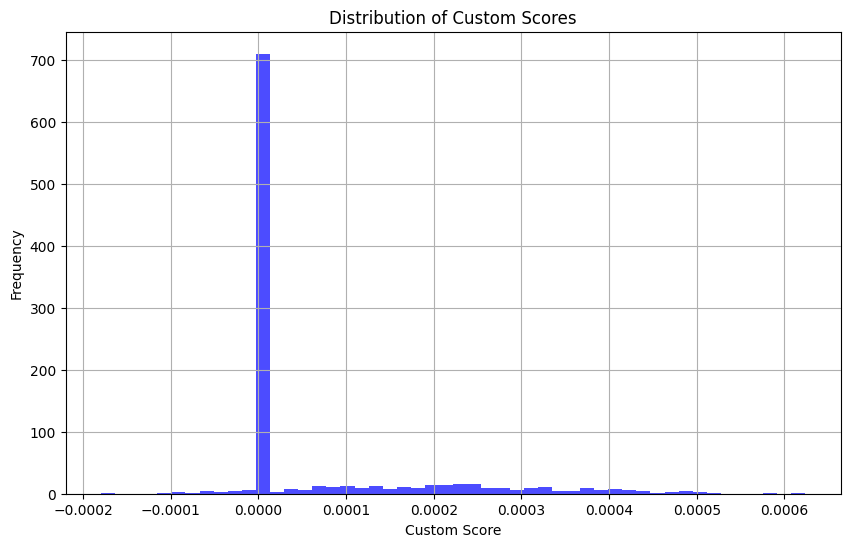

In [47]:
# Plot the distribution of custom scores
plt.figure(figsize=(10, 6))
plt.hist(custom_scores, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Custom Scores')
plt.xlabel('Custom Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()